<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/tutorials/PSD_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/tutorials/PSD_Analysis.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# PSD Analysis

The analysis notebook relies on the "Nuclear particle master" sheet to provide timestamps that allow us to separate the radiation data from experiments into several regions. In ideal experiments, we'll have:
- Set-up
- Calibration (30 min with source)
- Background 1 (12 hours)
- Experiment
- Background 2 (12 hours)

A PSD plot will be created for the calibration period in order to extract a `psp_threshold` that allows us to discriminate between gammas and neutrons. This threshold is then saved back to the master sheet.



## Running this notebook

Go ahead and change the `experiment_id` and channel number below and then run the whole notebook.

You will be asked a couple of time to authenticate with your Google account, but after that all the analysis will happen automatically.

In [101]:
experiment_id = 1

In [102]:
channel_number = 0

## Libraries

In [103]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Interacting with sheets
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text

#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Authentication

We need to do a few authentication steps:
- Bring in the database credentials from Google drive so that we can pull data from the live database.
- Bring in the nuclear particle master sheet ID
-  Authenticate Colab to pull the nuclear particle master sheet using the Drive API.

In [104]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [106]:
# Authenticate using Colab's built-in credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Extracting experimental timestamps

We need to
- Open the master sheet
- Find the row corresponding with the experiment
- Extract the timestamp columns

In [107]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df = pd.DataFrame(sheet.get_all_records())

In [108]:
# Find the row where Experiment ID matches
row = df[df['Experiment ID'] == experiment_id]

# Extract times from columns M, N, O, P, Q, R, S
times = row[['Setup', 'Calibration', 'Background 1', 'Experiment', 'Background 2', 'End']]

times = times.apply(pd.to_datetime)

# Display the extracted times
times.head()

,Setup,Calibration,Background 1,Experiment,Background 2,End
0,2024-12-17 19:50:00,2024-12-17 11:30:00,2024-12-18 12:01:00,2024-12-19 00:01:00,2025-01-05,2025-01-05 12:00:00


## Compiling PSD data from radiation events

We collect the time, energy and psp value of each radiation event and store it in a SQL database. In order to create a PSD plot and perform analysis, we need to work with 2D histogram. In other words, we need to count the number of events in given energy/psp buckets.

The database is optimised for performing these kind of aggregations over large volumes of data so we lean on its capabilities instead of attempting to bring all the data into python and then aggregating.


In [127]:
def get_psd_data(start_time, end_time):
  query = f"""
  SELECT
      width_bucket(channels[1], 0, 1, 128) AS psp_bin,
      width_bucket(channels[2], 0, 4000, 512) AS energy_bin,
      COUNT(*) AS count
  FROM caen8ch_ch{channel_number}
  WHERE time BETWEEN '{start_time}' AND '{end_time}'
  GROUP BY psp_bin, energy_bin
  ORDER BY psp_bin, energy_bin;
  """
  return pd.read_sql(query, engine, index_col=None)

def get_all_psd_data(times):
  psd_data = []
  for i in range(len(times.iloc[:,1:].values[0])):
    data = get_psd_data(times.iloc[0, i], times.iloc[0, i + 1])
    psd_data.append(data)
  return psd_data

def get_all_psd_data(times):
    psd_data = {}
    psd_periods = {}
    columns = times.columns[1:]  # Exclude the first column (index)
    for i in range(len(columns) - 1):
        start_time = times.iloc[0, i + 1]
        end_time = times.iloc[0, i + 2]
        if pd.notna(start_time) and pd.notna(end_time):
            data = get_psd_data(start_time, end_time)
            psd_data[columns[i]] = data
            psd_periods[columns[i]] = end_time - start_time
    return psd_data, psd_periods

We will now extract PSD data for all periods in our experiment.

In [128]:
psd_data, psd_periods  = get_all_psd_data(times)

Sometimes an experiment will be ongoing so we won't have data for the different periods yet. We'll create a helper function to check this for us so that we don't run into errors later on in the notebook.

In [111]:
# Checks to see if experimental data for a particular period exists
def data_exists(label):
    if label in psd_data:  # Check if dict key exists (false if there are no dates for this period in the master sheet)
        if len(psd_data[label]) > 0:  # Check if array is non-empty (false is there is no data for this period in the databse)
            return True
        else:
            return False
    else:
        return False

## Visualising the PSD plots

In [164]:
def plot_psd(data, period=None, title="PSD", psp_threshold=None, ax=None):
    # Initialise histogram
    hist = np.zeros((512, 128), dtype=int)

    if period is not None:
        days = period.days
        hours = period.components.hours
        days_str = f"{days} day" if days == 1 else f"{days} days" if days > 0 else ""
        hours_str = f"{hours} hour" if hours == 1 else f"{hours} hours"
        period_string = f"{days_str}, {hours_str}" if days > 0 else hours_str
        period_string = period_string.strip(", ")
    else:
        period_string = None

    # Accumulate counts
    for row in data.itertuples(index=False):
        psp_bin, energy_bin, count = row
        if 0 <= energy_bin < 512 and 0 <= psp_bin < 128:
            hist[energy_bin, psp_bin] += int(count)

    # Define bin edges
    energy_edges = np.linspace(0, 4000, 513)  # 512 bins → 513 edges
    psp_edges = np.linspace(0, 1, 129)        # 128 bins → 129 edges

    # Plot with pcolormesh and log colour scale
    if ax is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)

    im = ax.pcolormesh(energy_edges, psp_edges, hist.T,
                      norm=mcolors.LogNorm(vmin=1, vmax=hist.max()),
                      cmap='viridis', shading='auto')
    ax.set_xlabel('Energy')
    ax.set_ylabel('PSP')
    if period_string is not None:
        ax.set_title(f"{title} ({period_string})")
    else:
        ax.set_title(title)

    # Draw horizontal red line at psp_threshold if provided
    if psp_threshold is not None:
        if 0 <= psp_threshold <= 1:  # Ensure threshold is within PSP range [0, 1]
            ax.axhline(y=psp_threshold, color='red', linestyle='-', label=f'PSP Threshold: {psp_threshold:.3f}')
            ax.legend()

    # Add colorbar
    plt.colorbar(im, ax=ax, label='Count (log scale)')

    if ax is None:
        plt.show()

We begin with the calibration period for which we have the largest number of events due to the presence of a source of radiation. This PSD plot is what we'll use to extract a simple psp threshold value that can be used to quickly discriminate between gammas (lower psp) and neutrons (higher psp).  

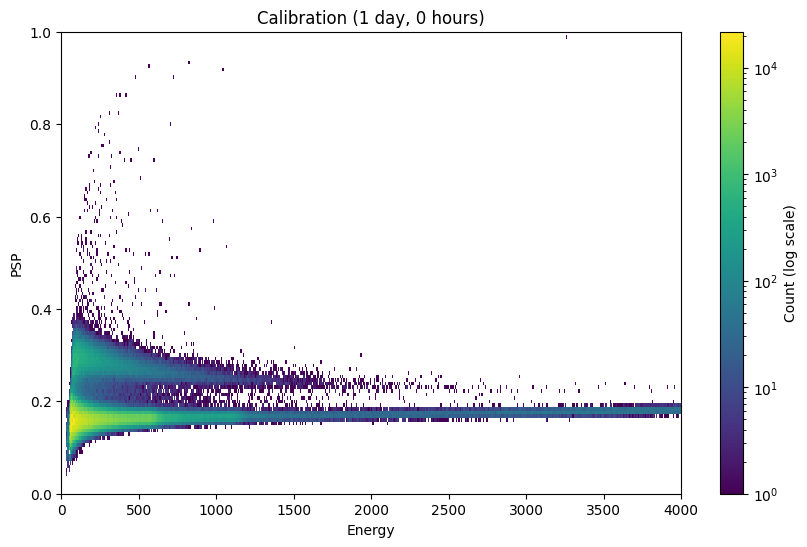

In [165]:
if data_exists("Calibration"):
  plot_psd(psd_data["Calibration"], psd_periods["Calibration"], "Calibration")
else:
  print("‼️ Calibration data does not exist, cannot create PSD plot. ‼️")


## Calculating the PSP threshold

The most accurate way to discriminate between gammas and neutrons is to create a fiducial lines. For the purpose of eyeballing neutron/gamma counts during a live experiment, a simple threshold psp value can be a good enough.

In this notebook, we trial a midpoint method.
- Choose an energy value
- Determine the psp locations of the gamma and neutron peaks
- Take the half way point between the two values.

In [166]:
def find_psp_midpoint(data, target_energy=500, energy_range=(0, 4000), psp_range=(0, 1), energy_bins=512, psp_bins=128):
    # Step 1: Map target_energy to the closest energy_bin
    bin_width = (energy_range[1] - energy_range[0]) / energy_bins  # 4000 / 512 = 7.8125
    closest_energy_bin = int(round(target_energy / bin_width))
    closest_energy_bin = max(1, min(closest_energy_bin, energy_bins))  # Clamp to [1, 512]
    print(f"Closest energy bin to {target_energy}: {closest_energy_bin}")

    # Step 2: Filter data for the closest energy_bin
    filtered_data = data[data['energy_bin'] == closest_energy_bin]
    if filtered_data.empty:
        raise ValueError(f"No data found for energy bin {closest_energy_bin} (energy ~{target_energy})")

    # Step 3: Prepare PSP distribution for peak detection
    psp_bin_width = (psp_range[1] - psp_range[0]) / psp_bins  # 1 / 128 = 0.0078125

    # Create a histogram-like array for the full PSP range
    hist = np.zeros(psp_bins)
    for idx, row in filtered_data.iterrows():
        psp_bin = row['psp_bin'] - 1  # Convert to 0-based index (since psp_bin is 1 to 128)
        count = row['count']
        if 0 <= psp_bin < psp_bins:
            hist[psp_bin] += count

    # Find peaks using scipy.signal.find_peaks
    peaks_indices, _ = find_peaks(hist, height=0, prominence=10)  # Adjust prominence as needed
    if len(peaks_indices) < 2:
        raise ValueError("Not enough significant peaks detected; adjust prominence or check data.")

    # Get the two highest peaks based on prominence
    peak_indices_sorted = sorted(peaks_indices, key=lambda x: hist[x], reverse=True)[:2]
    if len(peak_indices_sorted) < 2:
        raise ValueError("Not enough prominent peaks to determine midpoint.")

    # Convert peak indices to PSP values
    peak1_idx, peak2_idx = peak_indices_sorted[:2]
    peak1_value = (peak1_idx + 0.5) * psp_bin_width  # Bin center
    peak2_value = (peak2_idx + 0.5) * psp_bin_width  # Bin center
    peak1_value, peak2_value = sorted([peak1_value, peak2_value])  # Ensure peak1 < peak2
    print(f"Peak PSP values: {peak1_value:.6f}, {peak2_value:.6f}")

    # Step 4: Calculate midpoint in PSP units
    midpoint = (peak1_value + peak2_value) / 2
    print(f"Midpoint between PSP peaks: {midpoint:.6f}")

    # Step 5: Plot PSP distribution with peaks and midpoint
    plt.figure(figsize=(8, 5))
    psp_centers = np.arange(psp_bins) * psp_bin_width + psp_bin_width / 2  # Bin centers
    plt.bar(psp_centers, hist, width=psp_bin_width, alpha=0.7)
    plt.axvline(peak1_value, color='r', linestyle='--', label=f'Peak 1: {peak1_value:.3f}')
    plt.axvline(peak2_value, color='g', linestyle='--', label=f'Peak 2: {peak2_value:.3f}')
    plt.axvline(midpoint, color='b', label=f'Midpoint: {midpoint:.3f}')
    plt.xlabel('PSP')
    plt.ylabel('Count')
    plt.title(f'PSP Distribution at Energy ~{target_energy}')
    plt.legend()
    plt.show()

    return midpoint

In this analysis we'll use Energy  = 500

Closest energy bin to 500: 64
Peak PSP values: 0.152344, 0.261719
Midpoint between PSP peaks: 0.207031


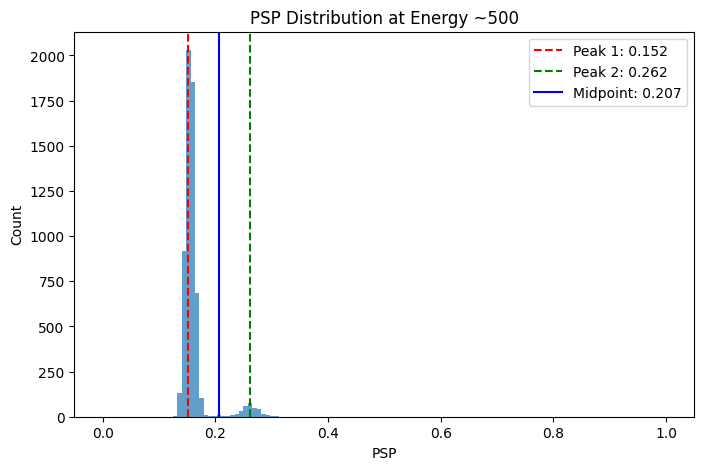

In [167]:
if data_exists("Calibration"):
  target_energy = 500
  psp_threshold = find_psp_midpoint(psd_data["Calibration"])
else:
  psp_threshold = None
  print("‼️ Calibration data does not exist, cannot perform psp thresold analysis ‼️")


Now that we have our threshold, we can remake the PSD plots to see if there is anything obviously wrong with the analysis.

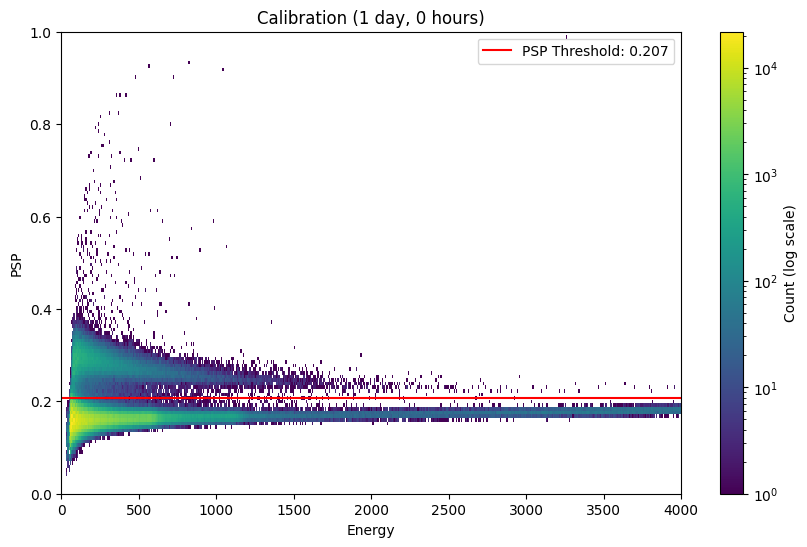

In [168]:
if data_exists("Calibration"):
  plot_psd(psd_data["Calibration"], psd_periods["Calibration"], "Calibration", psp_threshold)
else:
  print("‼️ Calibration data does not exist, cannot create PSD plot ‼️")

It can also be instructive to create the PSD plots for the background periods - we would not expect significant changes between the two. Here, we just eyeball them, but performing a statistical analysis will be the next step.

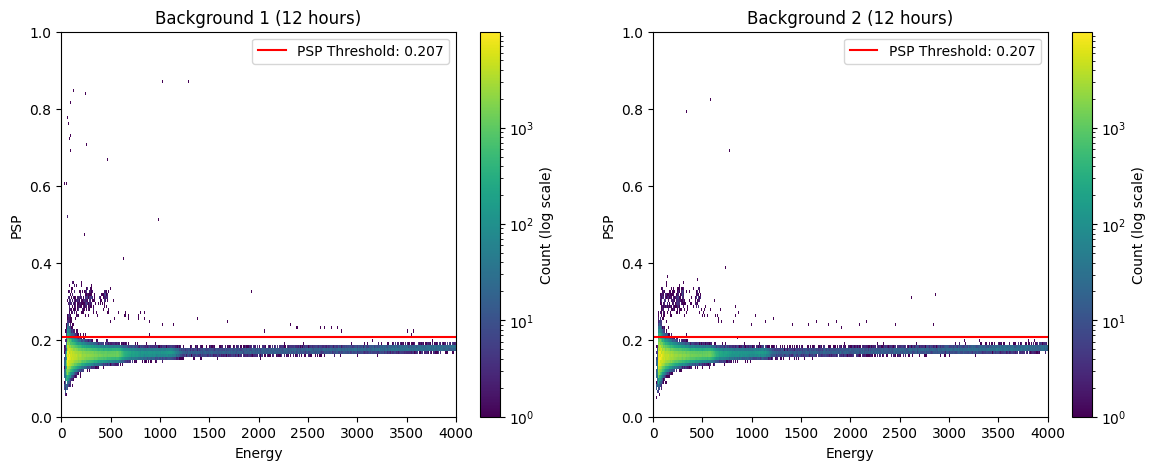

In [169]:
if data_exists("Background 1") and data_exists("Background 2"):
  fig, axes = plt.subplots(1, 2, figsize=(14, 5), squeeze=False)
  axes = axes.flatten()  # Flatten for easy indexing
  plot_psd(psd_data["Background 1"], psd_periods["Background 1"], 'Background 1', psp_threshold, ax=axes[0])
  plot_psd(psd_data["Background 2"], psd_periods["Background 2"], 'Background 2', psp_threshold, ax=axes[1])
elif data_exists("Background 1"):
  print("Background 2 data does not exist, plotting just Background 1 data")
  plot_psd(psd_data["Background 1"], psd_periods["Background 1"], 'Background 1', psp_threshold)
elif data_exists("Background 2"):
  print("Background 1 data does not exist, plotting just Background 2 data")
  plot_psd(psd_data["Background 2"], psd_periods["Background 2"], 'Background 2', psp_threshold)
else:
  print("‼️ Background data does not exist, cannot create PSD plots ‼️")

And of course we can look at the experimental period.

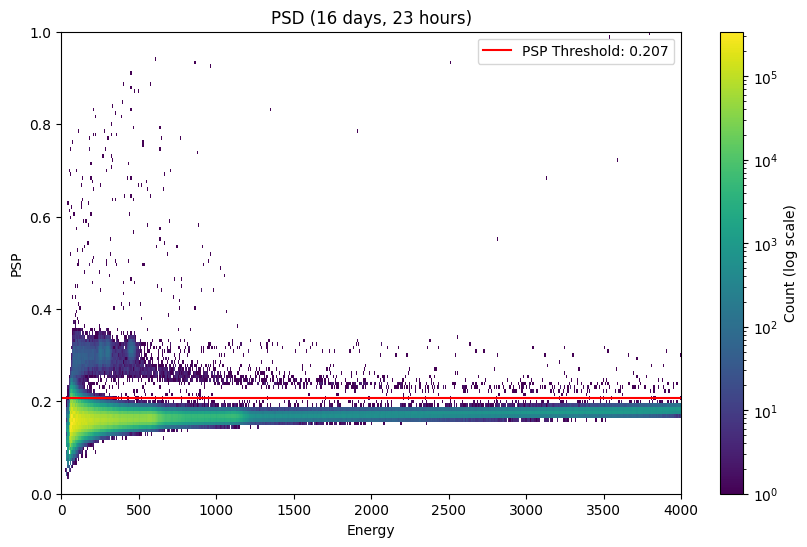

In [170]:
if data_exists("Experiment"):
  plot_psd(psd_data["Experiment"], psd_periods["Experiment"], psp_threshold=psp_threshold)
else:
  print("‼️ Exeperiment data does not exist, cannot create PSD plot ‼️")

Finally, we now update the master spreadsheet with the PSP threshold that will be used to gamma/neutron discrimination.

In [171]:
if psp_threshold is not None and "Calibration" in psd_data:
  # Update the DataFrame with the midpoint value
  if not row.empty:
      row_index = df.index[df['Experiment ID'] == experiment_id][0]
      df.at[row_index, 'psp threshold'] = psp_threshold  # Update the 'psp threshold' column
      print(f"Updated 'psp threshold' to {psp_threshold:.6f} for Experiment ID {experiment_id}")

      # Clean the DataFrame to handle NaN values
      df_clean = df.fillna('')  # Replace NaN with empty string, or use 0 if appropriate

      # Write the updated DataFrame back to the Google Sheet using gspread
      values = [df_clean.columns.tolist()] + df_clean.values.tolist()  # Header + data
      sheet.update(values, 'A1')  # Update starting at A1
      print("Google Sheet updated successfully.")
  else:
      print(f"No row found for Experiment ID {experiment_id}")
else:
  print("‼️ No psp threshold has been calculated. Nothing to upload to master sheet.")

Updated 'psp threshold' to 0.207031 for Experiment ID 1
Google Sheet updated successfully.
